In [75]:
import pandas as pd
import numpy as np
import requests
import os

datas_dir = "./unsplash-research-dataset-lite-latest"
image_dir_1024 = image_dir = "./images-1024"
image_dir_512 = "./images-512"

photos = pd.read_csv(os.path.join(datas_dir, "photos.tsv000"), sep="\t", header=0)

In [76]:
from PIL import Image
from io import BytesIO
from tqdm import tqdm

def download_images(frame: pd.DataFrame, *, width=1024, height=1024):

    if not os.path.exists(image_dir):
        os.mkdir(image_dir)

    for i in tqdm(range(len(frame))):
        row = frame.iloc[i]
        image_path = os.path.join(image_dir, f"{row.photo_id}.png")

        if os.path.exists(image_path):
            continue

        request = f"{row.photo_image_url}?w={width}&h={height}&fit=crop&crop=focalpoint,entropy"
        response = requests.get(request)
        image = Image.open(BytesIO(response.content)).convert("RGB")
        image.save(image_path)

def resize_images(frame: pd.DataFrame, *, width=512, height=512):

    if not os.path.exists(image_dir_512):
        os.mkdir(image_dir_512)

    for i in tqdm(range(len(frame))):
        row = frame.iloc[i]
        resized_path = os.path.join(image_dir_512, f"{row.photo_id}.png")

        if os.path.exists(resized_path):
            continue

        image_path = os.path.join(image_dir_1024, f"{row.photo_id}.png")
        image = Image.open(image_path)
        resized_image = image.resize((width, height))
        resized_image.save(resized_path)
        image.close()
        resized_image.close()


In [77]:
download_images(photos[:100])

100%|██████████| 100/100 [00:00<00:00, 322.65it/s]


In [79]:
resize_images(photos[:100])

100%|██████████| 100/100 [00:00<00:00, 339.52it/s]


In [118]:
import jax
import flax

from jax import numpy as jnp
from flax import linen as nn
from functools import partial

os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".50"

In [318]:
def load_batch(frame: pd.DataFrame, *, offset=0, batch_size=1, resolution=512):

    items = []
    for i in range(batch_size):
        row = frame.iloc[i + offset]
        test = Image.open(f"./images-{resolution}/{row.photo_id}.png")
        arr = jnp.asarray(test, dtype=jnp.float16) / 255.0
        items.append(arr)

    return jnp.array(items)

def view_batch(batch, index = 0):
    denorm = jnp.floor(batch[0] * 255.0)
    denorm = denorm.at[denorm < 0].set(0)
    denorm = denorm.at[denorm > 255].set(255)
    array = np.array(denorm, dtype=np.int8)
    image = Image.fromarray(array, mode="RGB")
    image.show()

batch = load_batch(photos[:100], offset=3)
batch.shape

(1, 512, 512, 3)

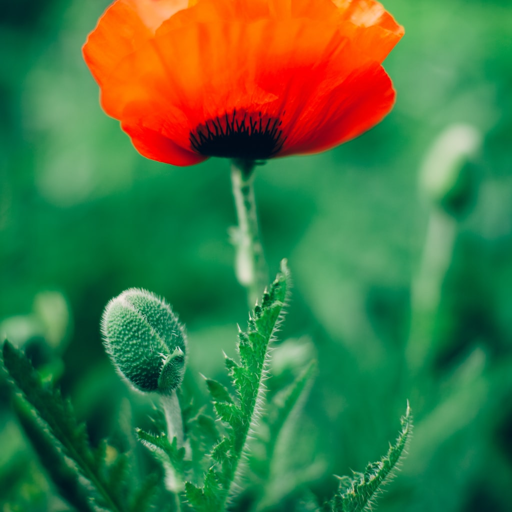

In [319]:
view_batch(batch, 0)

In [261]:
from dataclasses import dataclass, field
from typing import Sequence, List

class Encoder(nn.Module):
    kernel: (int, int) = (4, 4)
    channels: Sequence[int] = field(default_factory=lambda: [8, 16, 32, 64])

    @nn.compact
    def __call__(self, inputs, *args, **kwargs):
        batch_size, *image_shape = inputs.shape

        def conv(img, features):
            img = nn.Conv(features=features, kernel_size=self.kernel)(img)
            img = nn.relu(img)
            img = nn.avg_pool(img, window_shape=(2, 2), strides=(2, 2))
            return img

        x = inputs

        for c in self.channels:
            x = conv(x, c)

        return x

class Decoder(nn.Module):
    kernel: (int, int) = (4, 4)
    channels: Sequence[int] = field(default_factory=lambda: [32, 16, 8, 3])

    @nn.compact
    def __call__(self, inputs, *args, **kwargs):
        batch_size, *latent_size = inputs.shape

        def unconv(img, features):
            img = nn.ConvTranspose(features=features, kernel_size=self.kernel, strides=(2, 2))(img)
            img = nn.relu(img)
            return img

        x = inputs

        for c in self.channels:
            x = unconv(x, c)

        return x

class Autoencoder(nn.Module):
    encoder_kernel: (int, int) = (4, 4)
    decoder_kernel: (int, int) = (4, 4)
    encoder_channels: Sequence[int] = field(default_factory=lambda: [8, 16, 32, 64])
    decoder_channels: Sequence[int] = field(default_factory=lambda: [32, 16, 8, 3])

    @nn.compact
    def __call__(self, inputs, *args, **kwargs):
        x = inputs
        x = Encoder(kernel=self.encoder_kernel, channels=self.encoder_channels)(x)
        x = Decoder(kernel=self.decoder_kernel, channels=self.decoder_channels)(x)
        return x


In [262]:
key_root = jax.random.PRNGKey(0)
key_encoder, key_decoder, key_ae = jax.random.split(key_root, 3)

dummy = jnp.ones(batch.shape)
encoder = Encoder()
encoder_w = encoder.init(key_encoder, dummy)
latent = encoder.apply(encoder_w, dummy)
latent.shape

(1, 32, 32, 64)

In [264]:
decoder = Decoder()
decoder_w = decoder.init(key_decoder, latent)
decoded = decoder.apply(decoder_w, latent)
decoded.shape

(1, 512, 512, 3)

In [283]:
import optax

key_init, key_infer = jax.random.split(key_ae)

model = Autoencoder(
    encoder_kernel=(5, 5),
    decoder_kernel=(5, 5))

optim = optax.adam(0.001)

@jax.jit
def train_step(params, opt_state):

    @jax.jit
    def mse(params, x_batch, y_batch):
        y_pred = model.apply(params, x_batch)
        y_diff = jnp.square(y_pred - y_batch)
        return jnp.mean(y_diff)

    loss, grad = jax.value_and_grad(mse)(params, batch, batch)
    updates, opt_state = optim.update(grad, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss


In [290]:
auto_params = model.init(key_infer, batch)
auto_state = optim.init(auto_params)

In [306]:
for epoch in range(100):
    auto_params, auto_state, loss = train_step(auto_params, auto_state)
    if (epoch + 1) % 10 == 0:
        print(loss)


0.000575801
0.00031399552
0.00022474595
0.00018808867
0.00017211928
0.00016460275
0.00016075477
0.00015837196
0.00015682512
0.00015575024


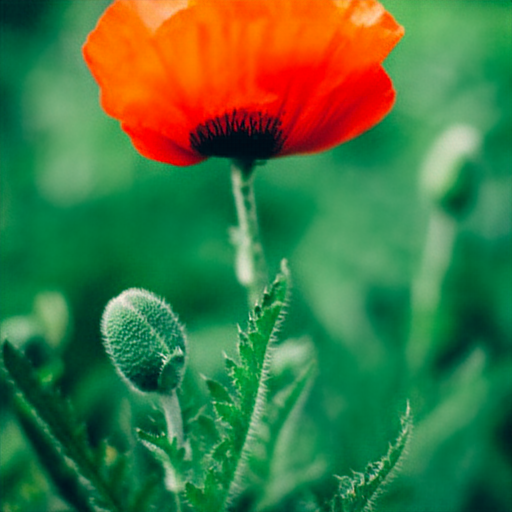

In [320]:
images = model.apply(auto_params, batch)
view_batch(images, 0)